In [3]:
# Imports
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import cv2
from PIL import Image

from matplotlib.patches import Rectangle
from os import listdir
from tqdm import tqdm
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns

In [9]:
DIRECTORY = "/kaggle/input/augmented-lfw/Augmented_LFW_final/Augmented_LFW_Final"

# Exploratory Data Analysis


(250, 250, 3, 3)


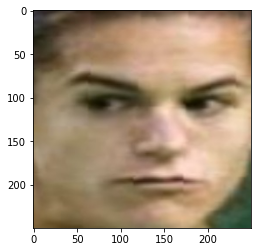

In [10]:
filename = "/kaggle/input/augmented-lfw/Augmented_LFW_final/Augmented_LFW_Final/Amelie_Mauresmo/1.jpg"
pixels = plt.imread(filename)

rgb_pixels = np.stack((pixels, pixels, pixels), axis=2)
print(rgb_pixels.shape)
plt.imshow(pixels)
plt.show()

# Building the dataset
We need to extract the faces for all of the images so that we can create our dataset for training/testing.

In [24]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical


In [29]:
def load_dataset(directory):
    images = []
    labels = []
    for subdir in os.listdir(directory):
        # Path to subfolder
        folder_path = os.path.join(directory, subdir)
        
        if os.path.isdir(folder_path):
            for file in os.listdir(folder_path):
                # Skip non-image files
                if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                    img_path = os.path.join(folder_path, file)
                    img = load_img(img_path, target_size=(250, 250))
                    img = img_to_array(img)
                    img /= 255.0  # Normalize to [0, 1]
                    images.append(img)
                    labels.append(subdir)  # Subfolder name as label

    return np.array(images), np.array(labels)

# Base directory containing subfolders with images
base_dir = '/kaggle/input/augmented-lfw/Augmented_LFW_final/Augmented_LFW_Final'
images, labels = load_dataset(base_dir)


In [28]:
print(images.shape)
print(labels.shape)

(3408, 250, 250, 3)
(3408,)


In [ ]:
print()

### Encoding and Splitting Dataset into Training and Validation Sets

In [30]:
# Encode labels into integers and then into one-hot vectors
encoder = LabelEncoder()
encoded_labels = encoder.fit_transform(labels)
categorical_labels = to_categorical(encoded_labels)

# Split the data into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(images, categorical_labels, test_size=0.2, random_state=42)

print(f'Training samples: {x_train.shape[0]}, Validation samples: {x_val.shape[0]}')


Training samples: 2726, Validation samples: 682


In [33]:
categorical_labels.shape

(3408, 50)

### Defining the CNN architecture

In [34]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

# Number of classes
num_classes = y_train.shape[1]

# Define the model
model = Sequential([
    # Convolutional layer 1
    Conv2D(32, (3, 3), activation='relu', input_shape=(250, 250, 3)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    
    # Convolutional layer 2
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    
    # Convolutional layer 3
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    
    # Flattening the 3D outputs to 1D
    Flatten(),
    
    # Fully connected Dense layer 1
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    
    # Output layer
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 248, 248, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 248, 248, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 124, 124, 32)      0         
_________________________________________________________________
dropout (Dropout)            (None, 124, 124, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 122, 122, 64)      18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 122, 122, 64)      256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 61, 61, 64)        0

### Training the model for 25 epochs. 

In [35]:
from tensorflow.keras.callbacks import EarlyStopping

# Define the early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    x_train, y_train,
    epochs=25,  # You can adjust this number as required
    batch_size=32,  # Adjust the batch size according to your system's capabilities
    validation_data=(x_val, y_val),
    callbacks=[early_stopping],
    verbose=1
)


Epoch 1/25
86/86 [==============================] - 26s 232ms/step - loss: 3.8155 - accuracy: 0.2052 - val_loss: 6.0972 - val_accuracy: 0.0425
Epoch 2/25
86/86 [==============================] - 19s 218ms/step - loss: 0.8811 - accuracy: 0.7773 - val_loss: 5.8902 - val_accuracy: 0.0645
Epoch 3/25
86/86 [==============================] - 19s 217ms/step - loss: 0.1683 - accuracy: 0.9673 - val_loss: 3.4753 - val_accuracy: 0.1891
Epoch 4/25
86/86 [==============================] - 19s 217ms/step - loss: 0.0985 - accuracy: 0.9799 - val_loss: 2.8693 - val_accuracy: 0.2111
Epoch 5/25
86/86 [==============================] - 19s 217ms/step - loss: 0.0501 - accuracy: 0.9963 - val_loss: 1.0193 - val_accuracy: 0.7317
Epoch 6/25
86/86 [==============================] - 19s 217ms/step - loss: 0.0265 - accuracy: 0.9971 - val_loss: 0.5329 - val_accuracy: 0.8871
Epoch 7/25
86/86 [==============================] - 19s 217ms/step - loss: 0.0182 - accuracy: 0.9973 - val_loss: 0.1199 - val_accuracy: 0.9751

### Plotting Loss and Accuracy Graphs

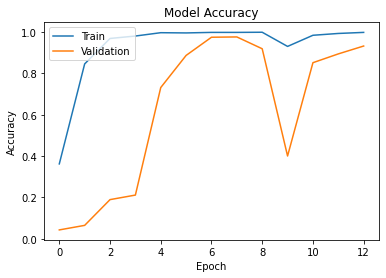

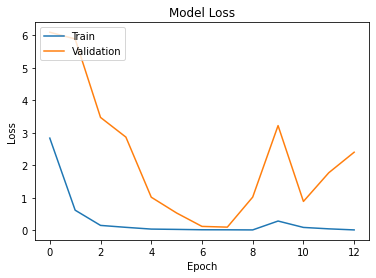

In [36]:
import matplotlib.pyplot as plt

# Summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


### Evaluating the model 

In [48]:
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score


# Predict classes on the validation set
y_pred = model.predict(x_val, batch_size=32)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_val, axis=1)

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred_classes)
report = classification_report(y_true, y_pred_classes, target_names=encoder.classes_)

accuracy_percentage = accuracy * 100

# Overall precision, recall, f1-score
overall_precision = precision_score(y_true, y_pred_classes, average='weighted')
overall_recall = recall_score(y_true, y_pred_classes, average='weighted')
overall_f1 = f1_score(y_true, y_pred_classes, average='weighted')

print(f'Overall Accuracy: {accuracy_percentage:.3f}%')
print(f'Overall Precision: {overall_precision:.3f}')
print(f'Overall Recall: {overall_recall:.3f}')
print(f'Overall F1-Score: {overall_f1:.3f}')

print(report)

Overall Accuracy: 97.654%
Overall Precision: 0.978
Overall Recall: 0.977
Overall F1-Score: 0.977
                        precision    recall  f1-score   support

       Amelie_Mauresmo       1.00      1.00      1.00        16
          Andre_Agassi       1.00      1.00      1.00        13
          Andy_Roddick       0.89      1.00      0.94         8
       Anna_Kournikova       1.00      1.00      1.00        12
         Ari_Fleischer       0.94      1.00      0.97        16
  Atal_Bihari_Vajpayee       0.93      1.00      0.97        14
          Bill_Clinton       1.00      0.88      0.93        16
        Britney_Spears       1.00      1.00      1.00        20
           Dick_Cheney       1.00      1.00      1.00        18
 Dominique_de_Villepin       0.95      1.00      0.97        18
          Fidel_Castro       0.94      1.00      0.97        15
           Halle_Berry       1.00      0.88      0.93         8
             Hans_Blix       1.00      0.92      0.96        13
      

### Checking Predictions on some random images. 

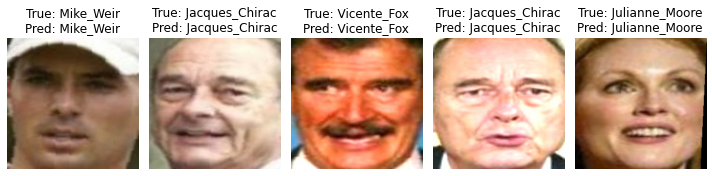

In [43]:
import matplotlib.pyplot as plt
import numpy as np

# Function to display images, true labels, and predicted labels in a larger subplot
def display_images_with_predictions(images, true_labels, predicted_labels, encoder, num_images=5):
    indices = np.random.choice(range(len(images)), num_images)
    plt.figure(figsize=(num_images * 2, 4))

    for i, index in enumerate(indices):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[index])
        true_label = encoder.inverse_transform([np.argmax(true_labels[index])])[0]
        predicted_label = encoder.inverse_transform([predicted_labels[index]])[0]
        plt.title(f'True: {true_label}\nPred: {predicted_label}', fontsize=12)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Generate predictions for the images
predicted_probs = model.predict(x_val, batch_size=32)
predicted_classes = np.argmax(predicted_probs, axis=1)

# Display images with true and predicted labels
display_images_with_predictions(x_val, y_val, predicted_classes, encoder)


In [49]:
model.save("/kaggle/working/LFW_model.h5")
print("Model saved")

Model saved


In [50]:
import tensorflow as tf

# Load the saved model
model = tf.keras.models.load_model("/kaggle/working/LFW_model.h5")

# Convert the model to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TensorFlow Lite model
with open("converted_model.tflite", "wb") as f:
    f.write(tflite_model)


In [52]:
import tensorflow as tf

# Load the saved model
model = tf.keras.models.load_model("/kaggle/working/LFW_model.h5")

# Convert the model to TensorFlow Lite format with post-training quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()
print("Debugging")
# Save the quantized TensorFlow Lite model
with open("quantized_model.tflite", "wb") as f:
    f.write(tflite_quantized_model)
    print("Quantized model saved.")


Debugging
Quantized model saved.
